In [1]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
using Plots
using Distributed
using LinearAlgebra
using JLD2

num_cores = length(Sys.cpu_info()) ; 
if nprocs()==1
    addprocs(num_cores; exeflags=`--project=$(Base.active_project())`)
end

@everywhere begin
    using LatticeAlgorithms
    using LinearAlgebra
    using Dates
    using BlockDiagonals
end


      From worker 51:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 51:	└   lock_file = "/local/home/maolinml/latticealgorithms.jl/.CondaPkg/lock"
      From worker 55:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 55:	└   lock_file = "/local/home/maolinml/latticealgorithms.jl/.CondaPkg/lock"
      From worker 47:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 47:	└   lock_file = "/local/home/maolinml/latticealgorithms.jl/.CondaPkg/lock"
      From worker 8:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 8:	└   lock_file = "/local/home/maolinml/latticealgorithms.jl/.CondaPkg/lock"
      From worker 13:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if 

In [3]:
println("num_cores = $(num_cores)")

num_cores = 96


In [4]:
type_lattice = "color_hexagonal"
χ = 64

# dmin, dmax = 3, 39
# σrange = vcat(0.50:0.01:0.59, 0.591:0.001:0.607, exp(-1/2))

dmin, dmax = 3, 5
σrange = 0.50:0.01:0.59


drange = dmin : 2 : dmax
σdrange = []
for σ in σrange
    for d in drange
        push!(σdrange, [σ, d])
    end
end

num_samples = Int(1e7)

num_samples_each_core = Int(ceil(num_samples/num_cores))
num_total_samples = Int(num_samples_each_core * num_cores);
println([num_samples_each_core, num_samples, num_total_samples])

logfile = "tn_$(type_lattice)_$(dmin)_$(dmax)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples)_log.txt"
    open(logfile, "w") do file
end

[104167, 10000000, 10000032]


In [5]:
@time results = pmap(1:num_cores) do _
    p_list = Dict(σdrange.=>[[0.0, 0.0, 0.0, 0.0] for _ in 1 : length(σdrange)])
    t_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    f_list = Dict(σdrange.=>[0   for _ in 1 : length(σdrange)])
    truncs = Dict(σdrange.=>[[0.0, 0.0, 0.0, 0.0] for _ in 1 : length(σdrange)])

    for (ind_σd, σd) in enumerate(σdrange)
        σ, d = σd[1], Int(σd[2])
        num_qubits = triangular_color_code_num_qubits(d)
        
        TN, indices = tn_template_color_hex(d)
        
        S_hex = [2 1; 0 √3] / (12)^(1/4);
        S_hex_T = Matrix(transpose(S_hex))
        bigS_T = BlockDiagonal([S_hex_T for _ in 1:num_qubits])
        bigS = BlockDiagonal([S_hex for _ in 1:num_qubits])
        M0 = triangular_color_code_M(d)
        M = M0 * bigS_T; 
        Mperp = GKP_logical_operator_generator(M)            
        Ω = Ω_matrix(M)
        invtransposeM = inv(transpose(M))
        
        logical = triangular_color_code_logicals(d)[1]
        X = zeros(2num_qubits)
        X[2 .* logical .- 1] .= 1
        Z = zeros(2num_qubits)
        Z[2 .* logical] .= 1

        Z = bigS * Z .* √π
        X = bigS * X .* √π
        
        pp = [0.0, 0.0, 0.0, 0.0]
        tt = 0.0
        fail = 0
        num_truncs = [0.0, 0.0, 0.0, 0.0]
        σdtime = @elapsed for _ in 1 : num_samples_each_core
            ξ = σ * randn(2num_qubits)
            
            if d == 17
                setprecision(BigFloat, 64)
                ξ = BigFloat.(ξ)                    
            end
            
            ξ2 = -√(2π) * M * Ω * ξ
            s = ξ2 - floor.(ξ2/(2π)) * 2π
            ηs = -transpose(Ω*Mperp) * s/√(2π) ; 
            b = inv(√(2π) * transpose(Mperp)) * (ηs-ξ)
            # @assert norm(round.(Int, b) - b) < 1e-10
            
            tt += @elapsed begin
                lstar = nothing
                try
                    lstar, prob_I, prob_X, prob_Y, prob_Z, num_truncs_I, num_truncs_X, num_truncs_Y, num_truncs_Z = tn_color_hex(ηs, σ, TN, indices, Z, X, χ)
                    num_truncs[1] += num_truncs_I
                    num_truncs[2] += num_truncs_X
                    num_truncs[3] += num_truncs_Y
                    num_truncs[4] += num_truncs_Z
                catch
                    fail += 1
                end

                lstar == nothing && (lstar = zeros(length(ηs)))
                
                rec = -ηs + lstar
                final_error = (rec+ξ)

                nx = transpose(final_error) * Ω * Z / π
                nz = transpose(final_error) * Ω * X / π
                nx = mod(round(nx), 2)
                nz = mod(round(nz), 2)
                @assert round.(Int, nx) ≈ nx
                @assert round.(Int, nz) ≈ nz  

                ##########
                if nx ≈ 0 && nz ≈ 0
                    pp[1] += 1
                elseif nx ≈ 1 && nz ≈ 0
                    pp[2] += 1
                elseif nx ≈ 0 && nz ≈ 1
                    pp[3] += 1
                elseif nx ≈ 1 && nz ≈ 1
                    pp[4] += 1
                end                    
            end
        end

        p_list[[σ, d]] .+= pp
        t_list[[σ, d]] += tt
        f_list[[σ, d]] += fail
        truncs[[σ, d]] .+= num_truncs

        if myid() == 2
            # Print the progress of the 2nd worker
            println(["$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))"])
            open(logfile, "a") do file
                write(file, "$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))\n")
            end
        end
    end
    return (p_list, t_list, f_list, truncs)
end ;

p_list = merge(.+, [res[1] for res in results]...)
t_list = merge(+, [res[2] for res in results]...)
f_list_0 = merge(+, [res[3] for res in results]...)
truncs_list = merge(.+, [res[4] for res in results]...)

f_list = Dict()
for (k, v) in f_list_0
    f_list[k] = Float64(v ./ num_total_samples)
end

map!(v->v./num_total_samples, values(t_list))
map!(v->v./num_total_samples, values(p_list))
map!(v->v./num_total_samples, values(truncs_list))

c_list = Dict()

for (k, v) in p_list
    c_list[k] = coherent_information_pauli_channel(v[2], v[4], v[3])
end



# Save the result
fn = "tn_$(type_lattice)_$(dmin)_$(dmax)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples).jld2";
jldsave(fn; 
    σrange=σrange, 
    num_samples=num_samples_each_core*num_cores,
    p_list = p_list,
    t_list = t_list,
    c_list = c_list,
    f_list = f_list,
    trunc_list = truncs_list,
    drange = drange
)


      From worker 2:	["1/20, 3, 690.677950204, 2024-10-15T13:20:42.105"]
      From worker 2:	["2/20, 5, 13405.435310284, 2024-10-15T17:04:10.269"]
      From worker 2:	["3/20, 3, 775.154367374, 2024-10-15T17:17:05.426"]
      From worker 2:	["4/20, 5, 13300.818394838, 2024-10-15T20:58:46.251"]
      From worker 2:	["5/20, 3, 768.975126839, 2024-10-15T21:11:35.230"]
      From worker 2:	["6/20, 5, 13071.168545849, 2024-10-16T00:49:26.406"]
      From worker 2:	["7/20, 3, 730.748086161, 2024-10-16T01:01:37.157"]
      From worker 2:	["8/20, 5, 13151.210993802, 2024-10-16T04:40:48.375"]
      From worker 2:	["9/20, 3, 753.47092889, 2024-10-16T04:53:21.851"]
      From worker 2:	["10/20, 5, 12832.37910819, 2024-10-16T08:27:14.236"]
      From worker 2:	["11/20, 3, 734.094062409, 2024-10-16T08:39:28.333"]
      From worker 2:	["12/20, 5, 13263.375420643, 2024-10-16T12:20:31.714"]
      From worker 2:	["13/20, 3, 808.584363724, 2024-10-16T12:34:00.302"]
      From worker 2:	["14/20, 5, 1343

In [6]:
sort(load(fn))

OrderedCollections.OrderedDict{String, Any} with 8 entries:
  "c_list"      => Dict{Any, Any}([0.51, 5.0]=>0.71257, [0.59, 5.0]=>-0.112696,…
  "drange"      => 3:2:5
  "f_list"      => Dict{Any, Any}([0.51, 5.0]=>9.99997e-8, [0.59, 5.0]=>0.0, [0…
  "num_samples" => 10000032
  "p_list"      => Dict([0.51, 5.0]=>[0.962933, 0.0122969, 0.0123681, 0.0124024…
  "t_list"      => Dict([0.51, 5.0]=>0.125832, [0.59, 5.0]=>0.121553, [0.52, 5.…
  "trunc_list"  => Dict([0.51, 5.0]=>[1.0, 1.0, 1.0, 1.0], [0.59, 5.0]=>[1.0, 1…
  "σrange"      => 0.5:0.01:0.59

# Compare to existing data

In [7]:
function get_p0list_sorted(p_list, drange, σrange)
    p0list_sorted = sort(p_list)
    p0list_sorted = collect(values(p0list_sorted))
    p0list_sorted = reshape(p0list_sorted, (length(drange), length(σrange)))
    p0list_sorted = [p0list_sorted[:,i] for i in 1:size(p0list_sorted,2)]
    return p0list_sorted
end


get_p0list_sorted (generic function with 1 method)

In [8]:
new_data = sort(load(fn))
new_p_list = new_data["p_list"]
new_p_list_sorted = get_p0list_sorted(new_p_list, drange, σrange)

10-element Vector{Vector{Vector{Float64}}}:
 [[0.9368513020758333, 0.0210451326555755, 0.021022132729175268, 0.021081432539415874], [0.9732053857427656, 0.008970071295771853, 0.008938771395931532, 0.00888577156553099]]
 [[0.9230543462260921, 0.02566231788058278, 0.025652117913222677, 0.025631217980102462], [0.9629327186153004, 0.01229686065004592, 0.012368060422206648, 0.012402360312447]]
 [[0.9077897950726558, 0.030672301848634086, 0.030705301743034423, 0.030832601335675724], [0.9499836600522878, 0.01669224658481093, 0.016678846627690792, 0.016645246735210447]]
 [[0.8907636495563214, 0.036401383515572754, 0.03640688349797281, 0.036428083430133026], [0.9341007108777252, 0.021906629898784325, 0.021983129653985106, 0.022009529569505377]]
 [[0.872560807805415, 0.042387264360754046, 0.04244006419179459, 0.04261186364203635], [0.915235071247772, 0.028266109548449447, 0.028241909625889197, 0.02825690957788935]]
 [[0.8527673711444124, 0.04902024313522197, 0.0489551433435413, 0.049257242376824

In [9]:
## 
# old_data = sort(load("data/raw_data/color_hex_3_7_64_13563760_threshold.jld2"))
old_data = sort(load("data/raw_data/color_hex_3_7_0.0_2.0_1.0_128_10016000.jld2"))
old_p_list = old_data["p_list"]

old_p_list_d = Dict()
for (k, v) in old_p_list
    if drange[1] <= k[2] <= drange[end]
        old_p_list_d[k] = v
    end
end

old_p_list_sorted = get_p0list_sorted(old_p_list_d, drange, old_data["σrange"])
display(old_p_list_sorted)


20-element Vector{Vector{Any}}:
 [[0.936854233226837, 0.021040634984025558, 0.020985323482428115, 0.021119808306709266], [0.9731459664536741, 0.008964257188498402, 0.008941094249201278, 0.008948682108626198]]
 [[0.9231604432907349, 0.025630990415335463, 0.025605431309904152, 0.02560313498402556], [0.9628681110223642, 0.01235982428115016, 0.012396265974440894, 0.012375798722044728]]
 [[0.9075445287539936, 0.030816593450479234, 0.03081259984025559, 0.030826277955271566], [0.9498926717252396, 0.01671775159744409, 0.016715654952076678, 0.016673921725239616]]
 [[0.890934804313099, 0.03634205271565495, 0.03633536341853035, 0.03638777955271565], [0.9341481629392971, 0.021906150159744408, 0.022022164536741214, 0.02192352236421725]]
 [[0.8725270567092652, 0.04248901757188498, 0.04259744408945687, 0.04238648162939297], [0.9151560503194888, 0.02828504392971246, 0.02832557907348243, 0.028233326677316293]]
 [[0.8528383586261981, 0.04907577875399361, 0.04911371805111821, 0.0489721445686901], [0.8933

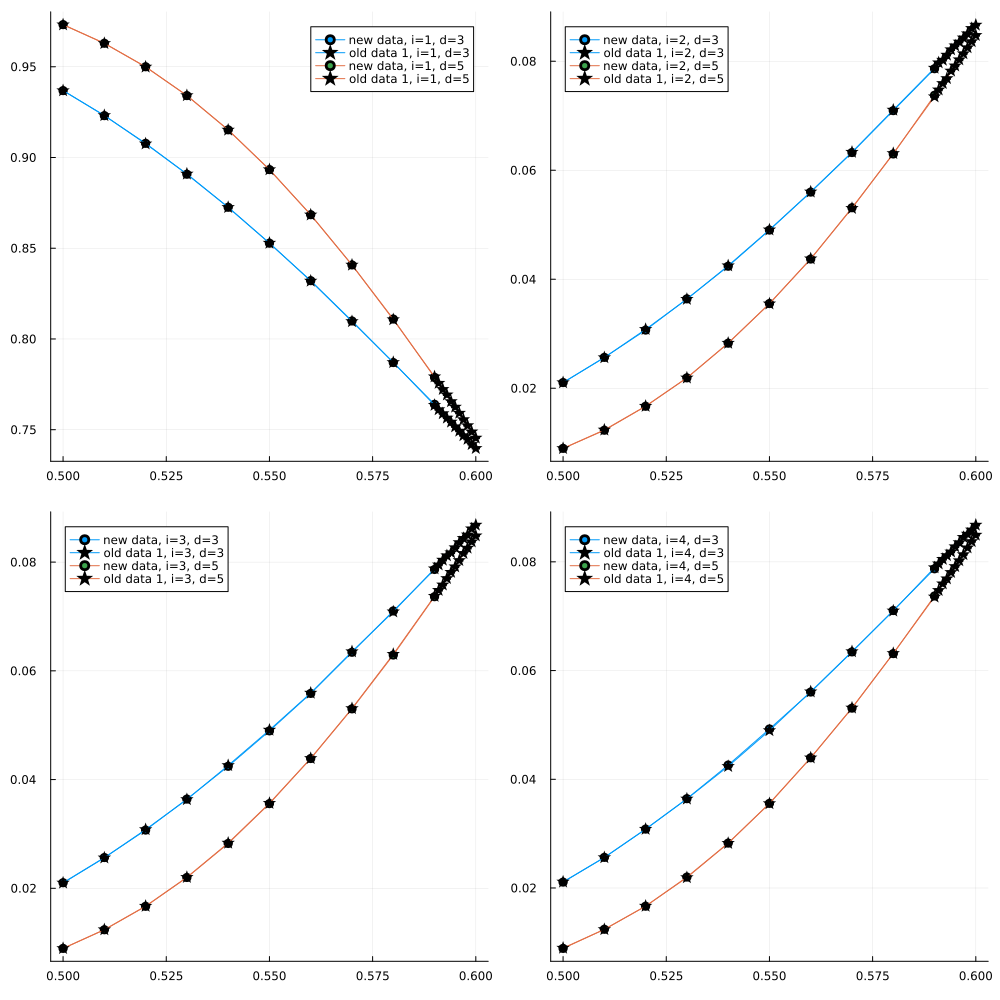

In [10]:
gs = []
linecolors = get_color_palette(:auto, plot_color(:white))

for i in 1:4
    g = plot()
    for (dind, d) in enumerate(drange)
        new_p_list = [item[dind][i] for item in new_p_list_sorted]
        old_p_list = [item[dind][i] for item in old_p_list_sorted]
        newyerr = sqrt.(new_p_list .* (1 .- new_p_list) ./ num_total_samples)
        oldyerr = sqrt.(old_p_list .* (1 .- old_p_list) ./ num_total_samples)
        plot!(σrange, new_p_list, marker=:circle, label="new data, i=$i, d=$d", linecolor=linecolors[dind], yerr=newyerr)
        plot!(old_data["σrange"], old_p_list, marker=:star, label="old data 1, i=$i, d=$d", linecolor=linecolors[dind], yerr=oldyerr)
    end
    push!(gs, g)    
end
plot(gs..., size=(1000, 1000))